# ACCESS-OM2 temp transects (prescribed)

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.lines as mlines
import gsw
import cmocean as cm

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36547/status,
Dashboard: /proxy/36547/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33057,Workers: 0
Dashboard: /proxy/36547/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44299,Total threads: 1
Dashboard: /proxy/36351/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36873,


In [4]:
#Importing data
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
def preprocess(ds):
    ds = ds[['temp','salt']].sel(yt_ocean=slice(-79,-62))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [6]:
## Time slicing
# Taking last 5 years 
cont = cont.sel(time=slice('1915-01-01','1919-12-31'))
melt = melt.sel(time=slice('1915-01-01','1919-12-31'))

### The transects I will take:

I am wanting transects from different regimes.
So, I am using:
- 110 W
- 260 W
- 42 W
<br>

### 110 W: Warm regime

In [10]:
cont_135W = cont.sel(xt_ocean='-110',method='nearest').mean('time')
melt_135W = melt.sel(xt_ocean='-110',method='nearest').mean('time')
cont_135W

<xarray.Dataset> Size: 243kB
Dimensions:   (st_ocean: 75, yt_ocean: 399)
Coordinates:
    xt_ocean  float64 8B -110.0
  * yt_ocean  (yt_ocean) float64 3kB -79.0 -78.95 -78.91 ... -62.08 -62.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    temp      (st_ocean, yt_ocean) float32 120kB dask.array<chunksize=(38, 220), meta=np.ndarray>
    salt      (st_ocean, yt_ocean) float32 120kB dask.array<chunksize=(38, 220), meta=np.ndarray>

In [26]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_135W['st_ocean'], cont_135W['yt_ocean'])
p_melt = gsw.p_from_z(-melt_135W['st_ocean'], melt_135W['yt_ocean'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_135W['salt'], p_cont, cont_135W['xt_ocean'], cont_135W['yt_ocean'])
SA_melt =  gsw.SA_from_SP(melt_135W['salt'], p_melt, melt_135W['xt_ocean'], melt_135W['yt_ocean'])

# Calculating conservative temperature
temp_135W_C = cont_135W['temp'] - 273.15
temp_135W_M = melt_135W['temp'] - 273.15

# Calculating potential density rho_1 
rho1_135W_C = gsw.sigma1(SA_cont, temp_135W_C)
rho1_135W_M = gsw.sigma1(SA_melt, temp_135W_M)

In [27]:
temp_135W_anom = temp_135W_M - temp_135W_C
temp_135W_anom.load()

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 399)> Size: 120kB
array([[        nan,         nan,         nan, ..., -0.12896729,
        -0.11660767, -0.11349487],
       [        nan,         nan,         nan, ..., -0.12911987,
        -0.11672974, -0.11364746],
       [        nan,         nan,         nan, ..., -0.12921143,
        -0.11679077, -0.11373901],
       ...,
       [        nan,         nan,         nan, ..., -0.00500488,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    xt_ocean  float64 8B -110.0
  * yt_ocean  (yt_ocean) float64 3kB -79.0 -78.95 -78.91 ... -62.08 -62.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [28]:
# To fix the label issues
temp_135W_anom.attrs['units'] = '°C'
temp_135W_anom.name = 'CT'

rho1_135W_C.attrs["units"] = "kg m^-3"
rho1_135W_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_135W_M.attrs["units"] = "kg m^-3"
rho1_135W_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [29]:
temp_135W_anom

<xarray.DataArray 'CT' (st_ocean: 75, yt_ocean: 399)> Size: 120kB
array([[        nan,         nan,         nan, ..., -0.12896729,
        -0.11660767, -0.11349487],
       [        nan,         nan,         nan, ..., -0.12911987,
        -0.11672974, -0.11364746],
       [        nan,         nan,         nan, ..., -0.12921143,
        -0.11679077, -0.11373901],
       ...,
       [        nan,         nan,         nan, ..., -0.00500488,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    xt_ocean  float64 8B -110.0
  * yt_ocean  (yt_ocean) float64 3kB -79.0 -78.95 -78.91 ... -62.08 -62.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    units:    °C

In [30]:
temp_135W_anom_new = temp_135W_anom.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-74,-69.5))
temp_135W_anom_new = temp_135W_anom_new.load()

In [31]:
rho1_135W_C_new = rho1_135W_C.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-74,-69.5))
rho1_135W_M_new = rho1_135W_M.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-74,-69.5))

In [32]:
rho1_135W_C_new.max().load()

<xarray.DataArray 'salt' ()> Size: 8B
array(32.51097868)
Coordinates:
    xt_ocean  float64 8B -110.0

In [33]:
rho1_135W_C_new.min().load()

<xarray.DataArray 'salt' ()> Size: 8B
array(31.74221308)
Coordinates:
    xt_ocean  float64 8B -110.0

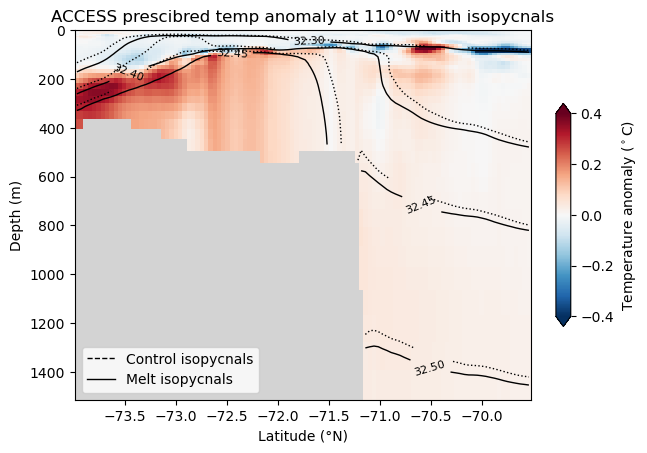

In [34]:
# Set grey background for the whole plot area (the axes)
plt.gca().set_facecolor('lightgrey')

# Plot your temperature anomaly
temp_135W_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cmap = plt.get_cmap('RdBu').reversed(),
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.3,32.4,32.45,32.50,32.52,32.54]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_135W_M_new['yt_ocean'],  
    rho1_135W_M_new['st_ocean'], 
    rho1_135W_M_new.transpose('st_ocean', 'yt_ocean'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_135W_C_new['yt_ocean'],  
    rho1_135W_C_new['st_ocean'], 
    rho1_135W_C_new.transpose('st_ocean', 'yt_ocean'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle='--', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")

# Add title
plt.title("ACCESS prescibred temp anomaly at 110°W with isopycnals")

plt.show()

In [35]:
temp_135W_anom_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_temp_prescribed_ACCESS.nc')
rho1_135W_C_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_rho1_C_prescribed_ACCESS.nc')
rho1_135W_M_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_rho1_M_prescribed_ACCESS.nc')

### 260W: Fresh regime

In [37]:
cont_260W = cont.sel(xt_ocean='-260',method='nearest').mean('time')
melt_260W = melt.sel(xt_ocean='-260',method='nearest').mean('time')
cont_260W

<xarray.Dataset> Size: 243kB
Dimensions:   (st_ocean: 75, yt_ocean: 399)
Coordinates:
    xt_ocean  float64 8B -260.0
  * yt_ocean  (yt_ocean) float64 3kB -79.0 -78.95 -78.91 ... -62.08 -62.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    temp      (st_ocean, yt_ocean) float32 120kB dask.array<chunksize=(38, 220), meta=np.ndarray>
    salt      (st_ocean, yt_ocean) float32 120kB dask.array<chunksize=(38, 220), meta=np.ndarray>

In [38]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_260W['st_ocean'], cont_260W['yt_ocean'])
p_melt = gsw.p_from_z(-melt_260W['st_ocean'], melt_260W['yt_ocean'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_260W['salt'], p_cont, cont_260W['xt_ocean'], cont_260W['yt_ocean'])
SA_melt =  gsw.SA_from_SP(melt_260W['salt'], p_melt, melt_260W['xt_ocean'], melt_260W['yt_ocean'])

# Calculating conservative temperature
temp_260W_C = cont_260W['temp'] - 273.15
temp_260W_M = melt_260W['temp'] - 273.15

# Calculating potential density rho_1 
rho1_260W_C = gsw.sigma1(SA_cont, temp_260W_C)
rho1_260W_M = gsw.sigma1(SA_melt, temp_260W_M)

In [39]:
temp_260W_anom = temp_260W_M - temp_260W_C
temp_260W_anom = temp_260W_anom.load()

In [40]:
# To fix the label issues
temp_260W_anom.attrs['units'] = '°C'
temp_260W_anom.name = 'CT'

rho1_260W_C.attrs["units"] = "kg m^-3"
rho1_260W_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_260W_M.attrs["units"] = "kg m^-3"
rho1_260W_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [42]:
temp_260W_anom_new = temp_260W_anom.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-66,-62.5))
temp_260W_anom_new = temp_260W_anom_new.load()

In [43]:
rho1_260W_C_new = rho1_260W_C.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-66,-62.5))
rho1_260W_M_new = rho1_260W_M.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-66,-62.5))

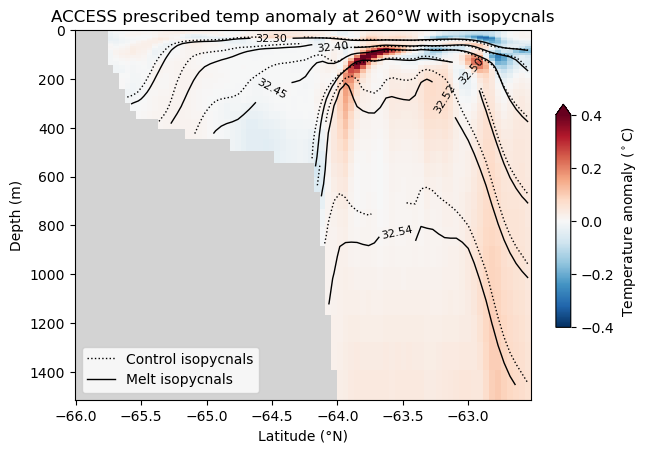

In [44]:
# Set grey background for the whole plot area (the axes)
plt.gca().set_facecolor('lightgrey')

# Plot your temperature anomaly
temp_260W_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cmap = plt.get_cmap('RdBu').reversed(),
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.3,32.4,32.45,32.50,32.52,32.54]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_260W_M_new['yt_ocean'],  
    rho1_260W_M_new['st_ocean'], 
    rho1_260W_M_new.transpose('st_ocean', 'yt_ocean'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_260W_C_new['yt_ocean'],  
    rho1_260W_C_new['st_ocean'], 
    rho1_260W_C_new.transpose('st_ocean', 'yt_ocean'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle=':', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")


# Add title
plt.title("ACCESS prescribed temp anomaly at 260°W with isopycnals")

plt.show()

In [54]:
temp_260W_anom_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_temp_prescribed_ACCESS.nc')
rho1_260W_C_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_rho1_C_prescribed_ACCESS.nc')
rho1_260W_M_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_rho1_M_prescribed_ACCESS.nc')

### Dense regime

In [46]:
cont_70E = cont.sel(xt_ocean='-42',method='nearest').mean('time')
melt_70E = melt.sel(xt_ocean='-42',method='nearest').mean('time')
cont_70E

<xarray.Dataset> Size: 243kB
Dimensions:   (st_ocean: 75, yt_ocean: 399)
Coordinates:
    xt_ocean  float64 8B -41.95
  * yt_ocean  (yt_ocean) float64 3kB -79.0 -78.95 -78.91 ... -62.08 -62.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    temp      (st_ocean, yt_ocean) float32 120kB dask.array<chunksize=(38, 220), meta=np.ndarray>
    salt      (st_ocean, yt_ocean) float32 120kB dask.array<chunksize=(38, 220), meta=np.ndarray>

In [47]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_70E['st_ocean'], cont_70E['yt_ocean'])
p_melt = gsw.p_from_z(-melt_70E['st_ocean'], melt_70E['yt_ocean'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_70E['salt'], p_cont, cont_70E['xt_ocean'], cont_70E['yt_ocean'])
SA_melt =  gsw.SA_from_SP(melt_70E['salt'], p_melt, melt_70E['xt_ocean'], melt_70E['yt_ocean'])

# Calculating conservative temperature
temp_70E_C = cont_70E['temp'] - 273.15
temp_70E_M = melt_70E['temp'] - 273.15

# Calculating potential density rho_1 
rho1_70E_C = gsw.sigma1(SA_cont, temp_70E_C)
rho1_70E_M = gsw.sigma1(SA_melt, temp_70E_M)

In [48]:
temp_70E_anom = temp_70E_M - temp_70E_C
temp_70E_anom = temp_70E_anom.load()

In [49]:
# To fix the label issues
temp_70E_anom.attrs['units'] = '°C'
temp_70E_anom.name = 'CT'

rho1_70E_C.attrs["units"] = "kg m^-3"
rho1_70E_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_70E_M.attrs["units"] = "kg m^-3"
rho1_70E_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [50]:
temp_70E_anom_new = temp_70E_anom.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-74.5,-72.5))
temp_70E_anom_new = temp_70E_anom_new.load()

In [51]:
rho1_70E_C_new = rho1_70E_C.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-74.5,-72.5))
rho1_70E_M_new = rho1_70E_M.sel(st_ocean=slice(0,1500)).sel(yt_ocean=slice(-74.5,-72.5))

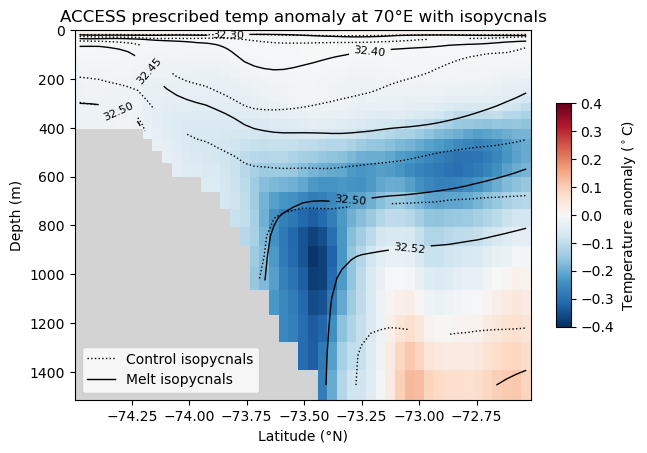

In [52]:
# Set grey background for the whole plot area (the axes)
plt.gca().set_facecolor('lightgrey')

# Plot your temperature anomaly
temp_70E_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cmap = plt.get_cmap('RdBu').reversed(),
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.3,32.4,32.45,32.50,32.52,32.54]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_70E_M_new['yt_ocean'],  
    rho1_70E_M_new['st_ocean'], 
    rho1_70E_M_new.transpose('st_ocean', 'yt_ocean'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_70E_C_new['yt_ocean'],  
    rho1_70E_C_new['st_ocean'], 
    rho1_70E_C_new.transpose('st_ocean', 'yt_ocean'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle=':', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")


# Add title
plt.title("ACCESS prescribed temp anomaly at 70°E with isopycnals")

plt.show()

In [53]:
temp_70E_anom_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_temp_prescribed_ACCESS.nc')
rho1_70E_C_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_rho1_C_prescribed_ACCESS.nc')
rho1_70E_M_new.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_rho1_M_prescribed_ACCESS.nc')